In [ ]:
# Importing the libraries
import random
import os
import json
import time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import cv2
import gym
import tensorflow as tf
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import (Add, Conv2D, Dense, Flatten, Input,
                                     Lambda, Subtract)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop

# Hyperparameters

In [2]:
# Hyperparameters

environment_name = 'BreakoutDeterministic-v4'

# Loading and saving information.
# If load_dir is None, it will train a new agent.
# If save_dir is None, it will not save the agent
load_dir = 'breakout-saves/save-04893595' # directory to load agent from
save_dir = None #'breakout-saves'
load_replay_buffer = True

clip_reward = True # Any positive reward is +1, and negative reward is -1, 0 is unchanged


n_frames = 2000000  # Total number of frames to train for
max_episode_len = 18000 # Maximum length of an episode (in frames).  18000 frames / 60 fps = 5 minutes


eval_length = 4000 # Number of frames to evaluate for
target_network_update_frequency = 10000 # Number of actions chosen between updating the target network

discount_factor_gamma = 0.99 # Gamma, how much to discount future rewards
min_replay_buffer_size = 50000 # The minimum size the replay buffer must be before we start to update the agent
max_replay_buffer_size = 1000000 # The maximum size of the replay buffer

n_random_oop = 20 # Randomly perform this number of actions before every evaluation to give it an element of randomness
actions_between_grad_steps = 4 # Number of actions between gradient descent steps

input_frame_shape = (84, 84) # Size of the preprocessed input frame. With the current model architecture, anything below ~80 won't work.
batch_size = 32 # Number of samples the agent learns from at once
learning_rate = 0.00001 # Learning rate of the optimizer


In [3]:
# This function is used to resize to any shape, we pass the shape required ie. (84,84)
def process_frame(frame, shape=(84, 84)):
    frame = frame.astype(np.uint8) 

    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[34:34+160, :160]  # crop image to remove score board and bottom black bar
    frame = cv2.resize(frame, shape, interpolation=cv2.INTER_NEAREST)
    frame = frame.reshape((*shape, 1))

    return frame

# Building Dueling Q Network Architecture

In [4]:
# This function builds a dueling DQN model using Keras, with specified input shape and number of actions
def build_q_network(n_actions, learning_rate=0.00001, input_shape=(84, 84), history_length=4):

    model_input = Input(shape=(input_shape[0], input_shape[1], history_length))
    x = Lambda(lambda layer: layer / 255)(model_input)  # normalize by 255 (max pixel value)

    x = Conv2D(32, (8, 8), strides=4, kernel_initializer=VarianceScaling(scale=2.), activation='relu', use_bias=False)(x)
    x = Conv2D(64, (4, 4), strides=2, kernel_initializer=VarianceScaling(scale=2.), activation='relu', use_bias=False)(x)
    x = Conv2D(64, (3, 3), strides=1, kernel_initializer=VarianceScaling(scale=2.), activation='relu', use_bias=False)(x)
    x = Conv2D(1024, (7, 7), strides=1, kernel_initializer=VarianceScaling(scale=2.), activation='relu', use_bias=False)(x)

    # Split into value and advantage streams (Dueling DQN)
    val_stream, adv_stream = Lambda(lambda w: tf.split(w, 2, 3))(x)  # custom splitting layer

    val_stream = Flatten()(val_stream)
    val = Dense(1, kernel_initializer=VarianceScaling(scale=2.))(val_stream)

    adv_stream = Flatten()(adv_stream)
    adv = Dense(n_actions, kernel_initializer=VarianceScaling(scale=2.))(adv_stream)

    # Combine streams into Q-Values
    reduce_mean = Lambda(lambda w: tf.reduce_mean(w, axis=1, keepdims=True))  # custom layer for reduce mean

    q_vals = Add()([val, Subtract()([adv, reduce_mean(adv)])])

    # Build model
    model = Model(model_input, q_vals)
    model.compile(Adam(learning_rate), loss=tf.keras.losses.Huber())

    return model

# Wrapper for the Gym environment

In [5]:
# This class is a wrapper for the environment, to perform reset and step functions, and to keep track of the state
class GameWrapper:

    def __init__(self, env_name, no_op_steps=10, history_length=4):
        self.env = gym.make(env_name, render_mode='rgb_array')
        self.env.metadata['render_fps'] = 30
        self.no_op_steps = no_op_steps
        self.history_length = 4

        self.state = None
        self.last_lives = 0

    # Resets the environment
    def reset(self, evaluation=False):

        self.frame = self.env.reset()
        self.last_lives = 0

        # If evaluating, take a random number of no-op steps.
        # This adds an element of randomness, so that the each
        # evaluation is slightly different.
        if evaluation:
            for _ in range(random.randint(0, self.no_op_steps)):
                self.env.step(1)

        # For the initial state, we stack the first frame four times
        self.state = np.repeat(process_frame(self.frame[0]), self.history_length, axis=2)

    # Performs an action to the environment and observes the result
    def step(self, action, render_mode=None):
    
        new_frame, reward, terminal, truncated, info = self.env.step(action)
        
        # In the commonly ignored 'info' or 'meta' data returned by env.step
        # we can get information such as the number of lives the agent has.

        # We use this here to find out when the agent loses a life, and
        # if so, we set life_lost to True.

        # We use life_lost to force the agent to start the game
        # and not sit around doing nothing.
        if info['lives'] < self.last_lives:
            life_lost = True
        else:
            life_lost = terminal
        self.last_lives = info['lives']
    
        processed_frame = process_frame(new_frame)
        self.state = np.append(self.state[:, :, 1:], processed_frame, axis=2)

        if render_mode == 'rgb_array':
            rgb_render = self.env.render()
            return processed_frame, reward, terminal, life_lost, rgb_render

        return processed_frame, reward, terminal, life_lost

# Replay Buffer to store the experience

In [6]:
# This replay buffer stores the agent's experiences and samples a random batch for training
class ReplayBuffer:

    def __init__(self, size=1000000, input_shape=(84, 84), history_length=4):
        self.size = size 
        self.input_shape = input_shape # (84, 84)
        self.history_length = history_length # 4
        self.count = 0  # total index of memory written to, always less than self.size
        self.current = 0  # index to write to

        # Pre-allocate memory
        self.actions = np.empty(self.size, dtype=np.int32) # Allocate memory for actions 
        self.rewards = np.empty(self.size, dtype=np.float32) # Allocate memory for rewards
        self.frames = np.empty((self.size, self.input_shape[0], self.input_shape[1]), dtype=np.uint8) # Allocate memory for frames
        self.terminal_flags = np.empty(self.size, dtype=bool) # Allocate memory for terminal flags


    def add_experience(self, action, frame, reward, terminal, clip_reward=True):
        
        if frame.shape != self.input_shape:
            raise ValueError('Dimension of frame is wrong!')

        if clip_reward:
            reward = np.sign(reward)

        # Write memory for the state that was just seen
        self.actions[self.current] = action 
        self.frames[self.current, ...] = frame 
        self.rewards[self.current] = reward
        self.terminal_flags[self.current] = terminal
        self.count = max(self.count, self.current+1)
        self.current = (self.current + 1) % self.size

    # Returns a minibatch of size batch_size
    def get_minibatch(self, batch_size=32):

        if self.count < self.history_length:
            raise ValueError('Not enough memories to get a minibatch')

        
        # Get a list of valid indices
        indices = []
        for i in range(batch_size):
            while True:
                # Get a random number from history_length to maximum frame written with probabilities                 
                index = random.randint(self.history_length, self.count - 1)

                # We check that all frames are from same episode with the two following if statements.  If either are True, the index is invalid.
                if index >= self.current and index - self.history_length <= self.current:
                    continue
                if self.terminal_flags[index - self.history_length:index].any():
                    continue
                break
            indices.append(index)

        # Retrieve states from memory
        states = []
        new_states = []
        for idx in indices:
            states.append(self.frames[idx-self.history_length:idx, ...])
            new_states.append(self.frames[idx-self.history_length+1:idx+1, ...])

        states = np.transpose(np.asarray(states), axes=(0, 2, 3, 1))
        new_states = np.transpose(np.asarray(new_states), axes=(0, 2, 3, 1))

        return states, self.actions[indices], self.rewards[indices], new_states, self.terminal_flags[indices]

    # Save the replay buffer to a folder
    def save(self, folder_name):

        if not os.path.isdir(folder_name):
            os.mkdir(folder_name)

        np.save(folder_name + '/actions.npy', self.actions)
        np.save(folder_name + '/frames.npy', self.frames)
        np.save(folder_name + '/rewards.npy', self.rewards)
        np.save(folder_name + '/terminal_flags.npy', self.terminal_flags)
        
    # Loads the replay buffer from a folder
    def load(self, folder_name):

        self.actions = np.load(folder_name + '/actions.npy')
        self.frames = np.load(folder_name + '/frames.npy')
        self.rewards = np.load(folder_name + '/rewards.npy')
        self.terminal_flags = np.load(folder_name + '/terminal_flags.npy')

# Implementing Agent

In [7]:
# Implements a standard DDDQN agent (Double Dueling Deep Q Network)
class Agent(object):
    def __init__(self,
                 dqn,
                 target_dqn,
                 replay_buffer,
                 n_actions,
                 input_shape=(84, 84),
                 batch_size=32,
                 history_length=4,
                 eps_initial=1,
                 eps_final=0.1,
                 eps_final_frame=0.01,
                 eps_evaluation=0.0,
                 eps_annealing_frames= 800000, # 1000000
                 replay_buffer_start_size=50000,
                 max_frames=2000000 # 18000000
                ):


        self.n_actions = n_actions
        self.input_shape = input_shape
        self.history_length = history_length

        # Memory information
        self.replay_buffer_start_size = replay_buffer_start_size
        self.max_frames = max_frames
        self.batch_size = batch_size

        self.replay_buffer = replay_buffer

        # Epsilon information
        self.eps_initial = eps_initial
        self.eps_final = eps_final
        self.eps_final_frame = eps_final_frame
        self.eps_evaluation = eps_evaluation
        self.eps_annealing_frames = eps_annealing_frames

        # Slopes and intercepts for exploration decrease
        # (Credit to Fabio M. Graetz for this and calculating epsilon based on frame number)
        self.slope = -(self.eps_initial - self.eps_final) / self.eps_annealing_frames
        self.intercept = self.eps_initial - self.slope*self.replay_buffer_start_size
        self.slope_2 = -(self.eps_final - self.eps_final_frame) / (self.max_frames - self.eps_annealing_frames - self.replay_buffer_start_size)
        self.intercept_2 = self.eps_final_frame - self.slope_2*self.max_frames

        # DQN
        self.DQN = dqn
        self.target_dqn = target_dqn
    # To get the appropriate epsilon value from a given frame number based on the epsilon schedule, change the decay rate.
    def calc_epsilon(self, frame_number, evaluation=False):

        if evaluation:
            return self.eps_evaluation
        elif frame_number < self.replay_buffer_start_size:
            return self.eps_initial
        elif frame_number >= self.replay_buffer_start_size and frame_number < self.replay_buffer_start_size + self.eps_annealing_frames:
            return self.slope*frame_number + self.intercept
        elif frame_number >= self.replay_buffer_start_size + self.eps_annealing_frames:
            return self.slope_2*frame_number + self.intercept_2


    # Query the DQN for an action given a state
    def get_action(self, frame_number, state, evaluation=False):

        # Calculate epsilon based on the frame number
        eps = self.calc_epsilon(frame_number, evaluation)

        if np.random.rand(1) < eps:
            return np.random.randint(0, self.n_actions)

        # Otherwise, query the DQN for an action
        q_vals = self.DQN.predict(state.reshape((-1, self.input_shape[0], self.input_shape[1], self.history_length)))[0]
        return q_vals.argmax()

    # Update the target Q network fir every predefined number of steps
    def update_target_network(self):
        
        self.target_dqn.set_weights(self.DQN.get_weights())

    # Wrapper function for adding an experience to the Agent's replay buffer
    def add_experience(self, action, frame, reward, terminal, clip_reward=True):

        self.replay_buffer.add_experience(action, frame, reward, terminal, clip_reward)

    # Uses a minibatch from the replay buffer to update the DQN and then updates the target network
    def learn(self, batch_size, gamma, frame_number):
    

        states, actions, rewards, new_states, terminal_flags = self.replay_buffer.get_minibatch(batch_size=self.batch_size)

        # Main DQN estimates best action in new states
        arg_q_max = self.DQN.predict(new_states).argmax(axis=1)

        # Target DQN estimates q-vals for new states
        future_q_vals = self.target_dqn.predict(new_states)
        double_q = future_q_vals[range(batch_size), arg_q_max]

        # Calculate targets (bellman equation)
        target_q = rewards + (gamma*double_q * (1-terminal_flags))

        # Use targets to calculate loss (and use loss to calculate gradients)
        with tf.GradientTape() as tape:
            q_values = self.DQN(states)

            one_hot_actions = tf.keras.utils.to_categorical(actions, self.n_actions, dtype=np.float32)  # using tf.one_hot causes strange errors
            Q = tf.reduce_sum(tf.multiply(q_values, one_hot_actions), axis=1)

            error = Q - target_q
            loss = tf.keras.losses.Huber()(target_q, Q)

        model_gradients = tape.gradient(loss, self.DQN.trainable_variables)
        self.DQN.optimizer.apply_gradients(zip(model_gradients, self.DQN.trainable_variables))

        return float(loss.numpy()), error


    # Saves the Agent and all corresponding properties into a folder       
    def save(self, folder_name, **kwargs):

        # Create the folder for saving the agent
        if not os.path.isdir(folder_name):
            os.makedirs(folder_name)

        # Save DQN and target DQN
        self.DQN.save(folder_name + '/dqn.h5')
        self.target_dqn.save(folder_name + '/target_dqn.h5')

        # Save replay buffer
        self.replay_buffer.save(folder_name + '/replay-buffer')

        # Save meta
        with open(folder_name + '/meta.json', 'w+') as f:
            f.write(json.dumps({**{'buff_count': self.replay_buffer.count, 'buff_curr': self.replay_buffer.current}, **kwargs}))  # save replay_buffer information and any other information

    def load(self, folder_name, load_replay_buffer=True):

        if not os.path.isdir(folder_name):
            raise ValueError(f'{folder_name} is not a valid directory')

        # Load DQNs
        self.DQN = tf.keras.models.load_model(folder_name + '/dqn.h5')
        self.target_dqn = tf.keras.models.load_model(folder_name + '/target_dqn.h5')
        self.optimizer = self.DQN.optimizer

        # Load replay buffer
        if load_replay_buffer:
            self.replay_buffer.load(folder_name + '/replay-buffer')

        # Load meta
        with open(folder_name + '/meta.json', 'r') as f:
            meta = json.load(f)

        if load_replay_buffer:
            self.replay_buffer.count = meta['buff_count']
            self.replay_buffer.current = meta['buff_curr']

        del meta['buff_count'], meta['buff_curr']  # we can delete, since we don't need to store these.
        return meta

# Creating environment

In [8]:
# Create environment
game_wrapper = GameWrapper(environment_name, n_random_oop)
print("The Atari Breakout has {} actions, they are: {}".format(game_wrapper.env.action_space.n, game_wrapper.env.unwrapped.get_action_meanings()))

# Build main and target networks
MAIN_DQN = build_q_network(game_wrapper.env.action_space.n, learning_rate, input_shape=input_frame_shape)
TARGET_DQN = build_q_network(game_wrapper.env.action_space.n, input_shape=input_frame_shape)

replay_buffer = ReplayBuffer(size=max_replay_buffer_size, input_shape=input_frame_shape)
agent = Agent(MAIN_DQN, TARGET_DQN, replay_buffer, game_wrapper.env.action_space.n, input_shape=input_frame_shape, batch_size=batch_size)

# Training and evaluation
if load_dir is None:
    frame_number = 0
    rewards = []
    loss_list = []
else:
    print('Loading from', load_dir)
    meta = agent.load(load_dir, load_replay_buffer)

    # Apply information loaded from meta
    frame_number = meta['frame_number']
    rewards = meta['rewards']
    loss_list = meta['loss_list']

The Atari Breakout has 4 actions, they are: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']
Loading from breakout-saves/save-01134992


# Training the agent to play Atari Breakout using Double Dueling Deep Q Learning

> I trained the model with code in a .py file and run the code in the terminal. This was done to save RAM memory consumed by IDE like Jupyter Notebook, and also some errors were supressed by IDE
Here, there is no output for training, I have saved the model in a .h5 file and used it to test the model in the next section. Snippets of output from training are shown in the report.

In [9]:
try:    
    while frame_number < n_frames:
        # Training
        start_time = time.time()
        game_wrapper.reset()
        life_lost = True
        episode_reward_sum = 0
        for _ in range(max_episode_len):
            # Get action
            action = agent.get_action(frame_number, game_wrapper.state)

            # Take step
            processed_frame, reward, terminal, life_lost = game_wrapper.step(action)
            
            frame_number += 1
            episode_reward_sum += reward

            # Add experience to replay memory
            agent.add_experience(action=action,
                                frame=processed_frame[:, :, 0],
                                reward=reward, clip_reward=clip_reward,
                                terminal=life_lost)

            # Update agent
            if frame_number % actions_between_grad_steps == 0 and agent.replay_buffer.count > min_replay_buffer_size:
                loss, _ = agent.learn(batch_size, gamma=discount_factor_gamma, frame_number=frame_number)
                loss_list.append(loss)

            # Update target network
            if frame_number % target_network_update_frequency == 0 and frame_number > min_replay_buffer_size:
                agent.update_target_network()

            # Break the loop when the game is over
            if terminal:
                terminal = False
                break

        rewards.append(episode_reward_sum)


        # Output the progress every 10 games
        if len(rewards) % 10 == 0:
            eps = agent.calc_epsilon(frame_number)
            print(f'Episode: {str(len(rewards)).zfill(6)}  Frame number: {str(frame_number).zfill(8)} Epsilon: {eps} Average reward: {np.mean(rewards[-10:]):0.1f}  Time taken: {(time.time() - start_time):.1f}s')


        # Save model
        if len(rewards) > 300 and save_dir is not None:
            agent.save(f'{save_dir}/save-{str(frame_number).zfill(8)}', frame_number=frame_number, rewards=rewards, loss_list=loss_list)
except KeyboardInterrupt:
    print('\nTraining exited early.')

    if save_dir is None:
        try:
            save_dir = input('Would you like to save the trained model? If so, type in a save path, otherwise, interrupt with ctrl+c. ')
        except KeyboardInterrupt:
            print('\nExiting...')

    if save_dir is not None:
        print('Saving...')
        agent.save(f'{save_dir}/save-{str(frame_number).zfill(8)}', frame_number=frame_number, rewards=rewards, loss_list=loss_list)
        print('Saved.')

# Plotting the training results

In [4]:
# Load the data
dir_name = "save-04893595"
with open('breakout-saves/'+dir_name+'/meta.json') as f:
    data = json.load(f)

In [5]:
print("Number of frames trained: ", data["frame_number"])
print("Number of episodes trained: ", len(data["rewards"]))

Number of frames trained:  1134992
Number of episodes trained:  3664


In [6]:
print("Highest score achieved: ", max(data["rewards"]))

Higest score achieved:  33.0


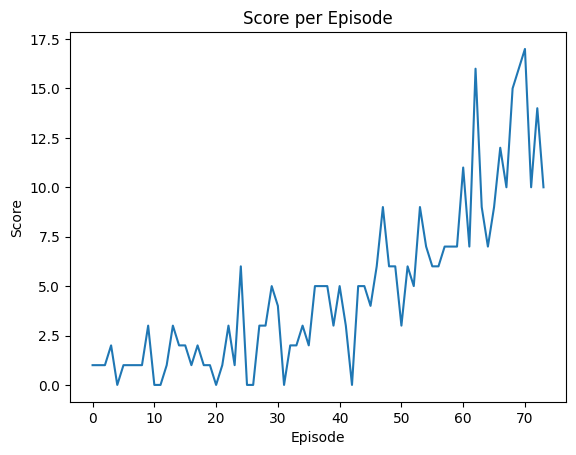

In [7]:
# plotting rewards per episode
plt.plot(data['rewards'][::50])
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Score per Episode')
plt.show()

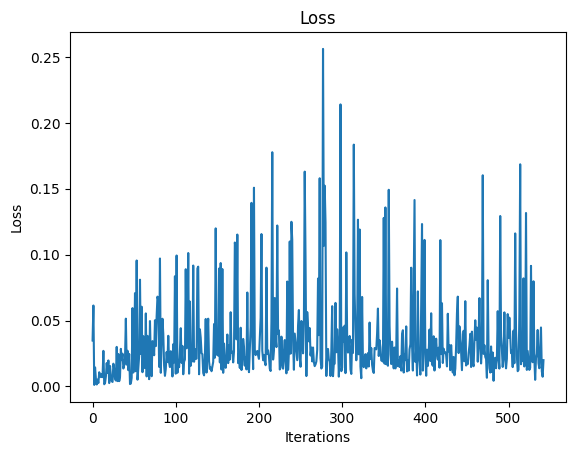

In [13]:
# Plotting the loss per iteration 
plt.plot(data['loss_list'][::500])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

# Evaluation of the model:

In [14]:
terminal = True
eval_rewards = []

frames_rgb = []

for _ in range(eval_length):
    if terminal:
        game_wrapper.reset(evaluation=True)
        life_lost = True
        episode_reward_sum = 0
        terminal = False

    # Breakout requires a "fire" action (action #1) to start the game each time a life is lost.    
    action = 1 if life_lost else agent.get_action(frame_number, game_wrapper.state, evaluation=True)
        
    # Step action
    _, reward, terminal, life_lost, render_rgb = game_wrapper.step(action, render_mode = "rgb_array")

    episode_reward_sum += reward
    frames_rgb.append(render_rgb)
    
    # On game-over
    if terminal:
        eval_rewards.append(episode_reward_sum)

if len(eval_rewards) > 0:
    final_score = np.mean(eval_rewards)
else:
    # In case the game is longer than the number of frames allowed
    final_score = episode_reward_sum
# Print score and write to tensorboard
print('Evaluation score:', final_score)

1/1 [==============================] - 0s 26ms/step
Evaluation score: 12.428571428571429


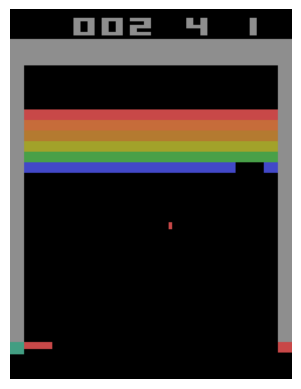

In [15]:
def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def update_scene(num, frames, patch):
        patch.set_data(frames[num])
        return patch,
    
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    writergif = animation.PillowWriter(fps=30)
    anim.save('animation.gif', writer=writergif)
    # show the animation in the jupyter notebook
    HTML(anim.to_jshtml())
    return anim

plot_animation(frames_rgb)


In [16]:
# Show .gif from file
from IPython.display import Image
Image(url='animation.gif')